In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [35]:
BATCH_SIZE = 64
EPOCHS = 30
LR = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [36]:
print("Loading data...")
pdb_maps = np.load('/content/drive/MyDrive/features/pdb_maps.npy')   # Source domain
af_maps = np.load('/content/drive/MyDrive/features/af_maps.npy')     # Target domain
labels = np.load('/content/drive/MyDrive/features/labels.npy')

# Add channel dimension: (N, 128, 128) → (N, 1, 128, 128)
pdb_maps = pdb_maps[:, np.newaxis, :, :]
af_maps = af_maps[:, np.newaxis, :, :]

print(f"PDB shape: {pdb_maps.shape}")
print(f"AF shape: {af_maps.shape}")

Loading data...
PDB shape: (12052, 1, 128, 128)
AF shape: (12052, 1, 128, 128)


In [37]:
#train test split
X_train, X_val, y_train, y_val = train_test_split(
    pdb_maps, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test (AF): {af_maps.shape[0]}")

# Convert to tensors
train_dataset = TensorDataset(
    torch.FloatTensor(X_train),
    torch.LongTensor(y_train)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val),
    torch.LongTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(af_maps),
    torch.LongTensor(labels)  # For evaluation only
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train: 9641, Val: 2411, Test (AF): 12052


In [38]:
class FeatureExtractor(nn.Module):
    """CNN that extracts features from contact maps."""
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # Layer 1: 1x128x128 → 32x64x64
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Layer 2: 32x64x64 → 64x32x32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Layer 3: 64x32x32 → 128x16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Layer 4: 128x16x16 → 256x8x8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Global average pooling → 256-dim vector
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 256)
        return x

In [39]:
class Classifier(nn.Module):
    """Classification head."""
    def __init__(self, input_dim=256, num_classes=7):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


In [40]:
class NaiveModel(nn.Module):
    """Complete model: Feature Extractor + Classifier."""
    def __init__(self, num_classes=7):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = Classifier(256, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

In [44]:
model = NaiveModel(num_classes=7).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def evaluate(model, loader):
    """Calculate accuracy on a data loader."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            outputs = model(X)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

In [45]:
train_losses = []
val_accs = []
test_accs = []

print("\n=== Training Naive Model ===")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    val_acc = evaluate(model, val_loader)
    test_acc = evaluate(model, test_loader)

    train_losses.append(avg_loss)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | Test (AF) Acc: {test_acc:.4f}")



=== Training Naive Model ===
Epoch 5/30 | Loss: 0.5827 | Val Acc: 0.7088 | Test (AF) Acc: 0.7110
Epoch 10/30 | Loss: 0.3403 | Val Acc: 0.7279 | Test (AF) Acc: 0.7310
Epoch 15/30 | Loss: 0.1891 | Val Acc: 0.4878 | Test (AF) Acc: 0.5010
Epoch 20/30 | Loss: 0.1258 | Val Acc: 0.1954 | Test (AF) Acc: 0.1913
Epoch 25/30 | Loss: 0.0731 | Val Acc: 0.6545 | Test (AF) Acc: 0.6477
Epoch 30/30 | Loss: 0.0729 | Val Acc: 0.7151 | Test (AF) Acc: 0.7201


In [46]:
print("\n=== Final Results ===")
final_val_acc = evaluate(model, val_loader)
final_test_acc = evaluate(model, test_loader)

print(f"Source (PDB) Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"Target (AlphaFold) Test Accuracy: {final_test_acc:.4f} ({final_test_acc*100:.1f}%)")
print(f"Accuracy Drop: {(final_val_acc - final_test_acc)*100:.1f}%")



=== Final Results ===
Source (PDB) Validation Accuracy: 0.7151 (71.5%)
Target (AlphaFold) Test Accuracy: 0.7201 (72.0%)
Accuracy Drop: -0.5%



Model saved to myDrive/naive_model.pth
Plot saved to research_implementation/naive/naive_training.png


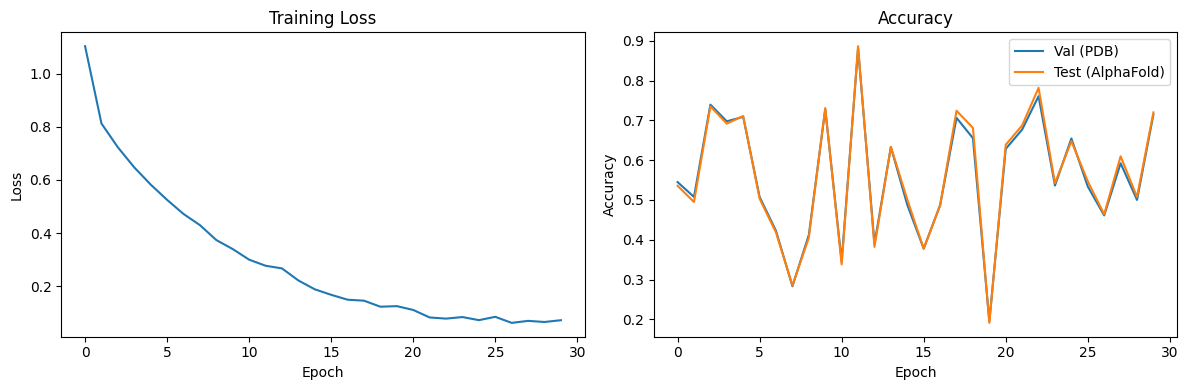

In [50]:
torch.save(model.state_dict(), '/content/drive/MyDrive/features/naive_model.pth')
print("\nModel saved to myDrive/naive_model.pth")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val (PDB)')
plt.plot(test_accs, label='Test (AlphaFold)')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/features/naive_training.png')

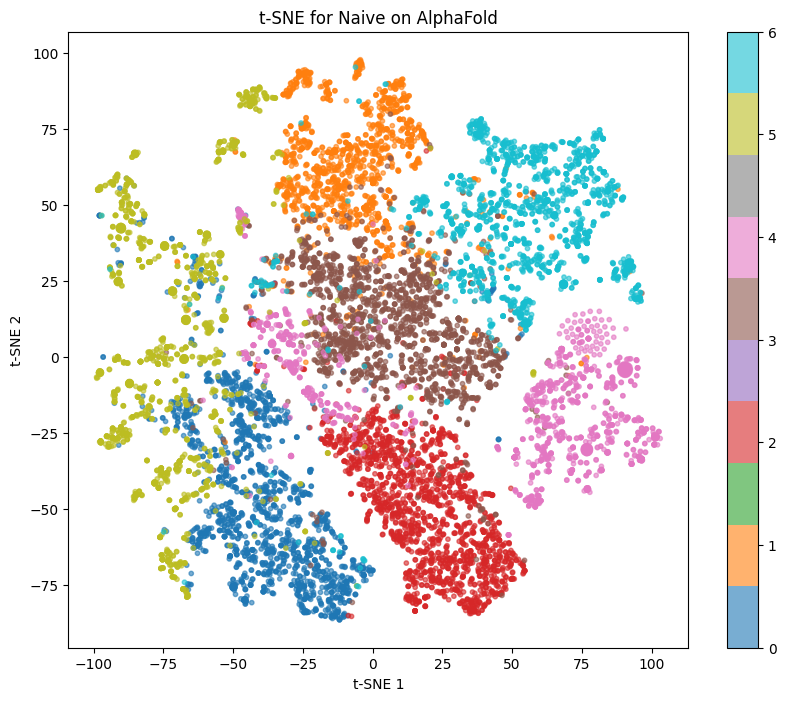

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract features from the model
model.eval()
features = []
labels_list = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(DEVICE)
        feat = model.feature_extractor(X)  # Get features before classifier
        features.append(feat.cpu().numpy())
        labels_list.append(y.numpy())

features = np.concatenate(features)
labels_list = np.concatenate(labels_list)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_list, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter)
plt.title('t-SNE for Naive on AlphaFold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

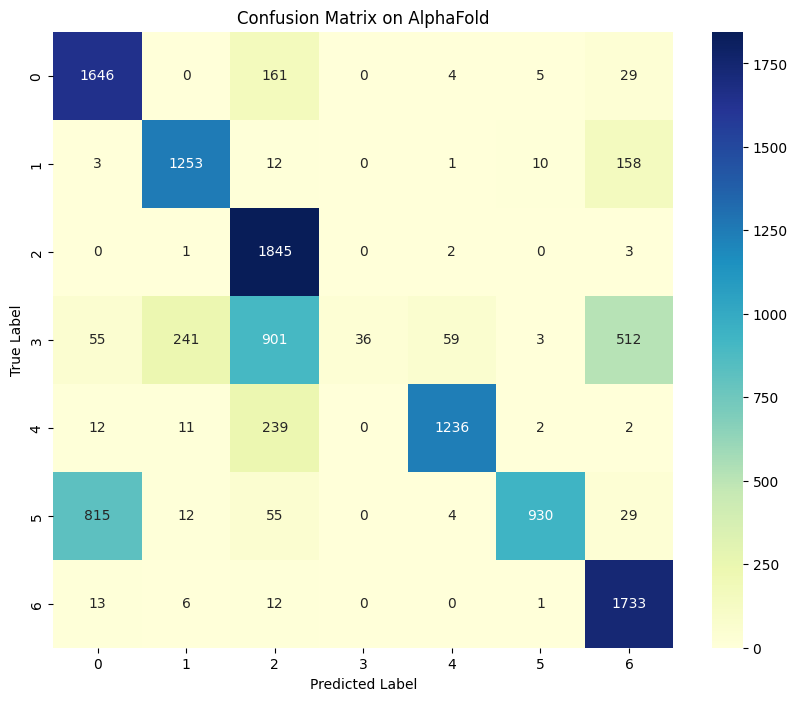

              precision    recall  f1-score   support

           0       0.65      0.89      0.75      1845
           1       0.82      0.87      0.85      1437
           2       0.57      1.00      0.73      1851
           3       1.00      0.02      0.04      1807
           4       0.95      0.82      0.88      1502
           5       0.98      0.50      0.67      1845
           6       0.70      0.98      0.82      1765

    accuracy                           0.72     12052
   macro avg       0.81      0.73      0.68     12052
weighted avg       0.81      0.72      0.66     12052



In [49]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(DEVICE)
        outputs = model(X)
        _, preds = outputs.max(1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix on AlphaFold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report (precision, recall, F1)
print(classification_report(all_labels, all_preds))